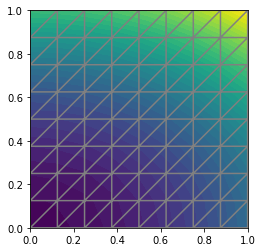

In [1]:
%matplotlib inline
# Ejemplo 1
"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.

  -Laplace(u) = f    in the unit square
            u = u_D  on the boundary

  u_D = 1 + x^2 + 2y^2
    f = -6
"""

from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution and mesh
plot(u)
plot(mesh)

# Save solution to file in XDMF format
xdmffile = XDMFFile('poisson/solution.xdmf')
xdmffile.write(u)

# Hold plot
plt.show()

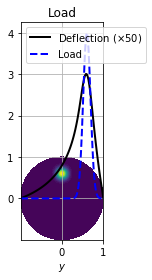

In [2]:
%matplotlib inline
# Ejemplo 2
"""
FEniCS tutorial demo program: Deflection of a membrane.

  -Laplace(w) = p  in the unit circle
            w = 0  on the boundary

The load p is a Gaussian function centered at (0, 0.6).
"""

#from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np

# Create mesh and define function space
domain = Circle(Point(0, 0), 1)
mesh = generate_mesh(domain, 64)
V = FunctionSpace(mesh, 'P', 2)

# Define boundary condition
w_D = Constant(0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, w_D, boundary)

# Define load
beta = 8
R0 = 0.6
p = Expression('4*exp(-pow(beta, 2)*(pow(x[0], 2) + pow(x[1] - R0, 2)))',
               degree=1, beta=beta, R0=R0)

# Define variational problem
w = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(w), grad(v))*dx
L = p*v*dx

# Compute solution
w = Function(V)
solve(a == L, w, bc)

# Plot solution
p = interpolate(p, V)
plot(w, title='Deflection')
plot(p, title='Load')

# Save solution to file in XDMF format
xdmffile_w = XDMFFile('poisson_membrane/deflection.xdmf')
xdmffile_w.write(w)

xdmffile_p = XDMFFile('poisson_membrane/load.xdmf')
xdmffile_p.write(p)

# Curve plot along x = 0 comparing p and w
import numpy as np
import matplotlib.pyplot as plt
tol = 0.001  # avoid hitting points outside the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y]  # 2D points
w_line = np.array([w(point) for point in points])
p_line = np.array([p(point) for point in points])
plt.plot(y, 50*w_line, 'k', linewidth=2)  # magnify w
plt.plot(y, p_line, 'b--', linewidth=2)
plt.grid(True)
plt.xlabel('$y$')
plt.legend(['Deflection ($\\times 50$)', 'Load'], loc='upper left')
plt.savefig('poisson_membrane/curves.pdf')
plt.savefig('poisson_membrane/curves.png')

# Hold plots
plt.show()


0 out of 100
1 out of 100
2 out of 100
3 out of 100
4 out of 100
5 out of 100
6 out of 100
7 out of 100
8 out of 100
9 out of 100
10 out of 100
11 out of 100
12 out of 100
13 out of 100
14 out of 100
15 out of 100
16 out of 100
17 out of 100
18 out of 100
19 out of 100
20 out of 100
21 out of 100
22 out of 100
23 out of 100
24 out of 100
25 out of 100
26 out of 100
27 out of 100
28 out of 100
29 out of 100
30 out of 100
31 out of 100
32 out of 100
33 out of 100
34 out of 100
35 out of 100
36 out of 100
37 out of 100
38 out of 100
39 out of 100
40 out of 100
41 out of 100
42 out of 100
43 out of 100
44 out of 100
45 out of 100
46 out of 100
47 out of 100
48 out of 100
49 out of 100
50 out of 100
51 out of 100
52 out of 100
53 out of 100
54 out of 100
55 out of 100
56 out of 100
57 out of 100
58 out of 100
59 out of 100
60 out of 100
61 out of 100
62 out of 100
63 out of 100
64 out of 100
65 out of 100
66 out of 100
67 out of 100
68 out of 100
69 out of 100
70 out of 100
71 out of 100
72

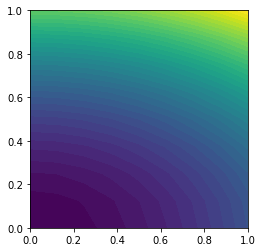

In [3]:
%matplotlib inline
# Ejemplo 3
"""
FEniCS tutorial demo program: Heat equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.

  u'= Laplace(u) + f  in the unit square
  u = u_D             on the boundary
  u = u_0             at t = 0

  u = 1 + x^2 + alpha*y^2 + \beta*t
  f = beta - 2 - 2*alpha
"""

#from __future__ import print_function
from fenics import *
import numpy as np

T = 2.0            # final time
num_steps = 100     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Create XDMF file for saving solution
xdmffile = XDMFFile('heat/solution.xdmf')

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):
    print('{} out of {}'.format(n, num_steps))

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Save to file and plot solution
    xdmffile.write(u, t)
    plot(u)

    # Update previous solution
    u_n.assign(u)

In [4]:
%matplotlib inline
# Ejemplo 4
"""
FEniCS tutorial demo program: Diffusion of a Gaussian hill.

  u'= Laplace(u) + f  in a square domain
  u = u_D             on the boundary
  u = u_0             at t = 0

  u_D = f = 0

The initial condition u_0 is chosen as a Gaussian hill.
"""

#from __future__ import print_function
from fenics import *
import time

T = 2.0            # final time
num_steps = 100     # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))',
                 degree=2, a=5)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Create XDMF file for saving solution
xdmffile = XDMFFile('heat_gaussian/solution.xdmf')

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):
    print('{} out of {}'.format(n, num_steps))

    # Update current time
    t += dt

    # Compute solution
    solve(a == L, u, bc)

    # Save to file and plot solution
    xdmffile.write(u, t)
    # plot(u)

    # Update previous solution
    u_n.assign(u)



0 out of 100
1 out of 100
2 out of 100
3 out of 100
4 out of 100
5 out of 100
6 out of 100
7 out of 100
8 out of 100
9 out of 100
10 out of 100
11 out of 100
12 out of 100
13 out of 100
14 out of 100
15 out of 100
16 out of 100
17 out of 100
18 out of 100
19 out of 100
20 out of 100
21 out of 100
22 out of 100
23 out of 100
24 out of 100
25 out of 100
26 out of 100
27 out of 100
28 out of 100
29 out of 100
30 out of 100
31 out of 100
32 out of 100
33 out of 100
34 out of 100
35 out of 100
36 out of 100
37 out of 100
38 out of 100
39 out of 100
40 out of 100
41 out of 100
42 out of 100
43 out of 100
44 out of 100
45 out of 100
46 out of 100
47 out of 100
48 out of 100
49 out of 100
50 out of 100
51 out of 100
52 out of 100
53 out of 100
54 out of 100
55 out of 100
56 out of 100
57 out of 100
58 out of 100
59 out of 100
60 out of 100
61 out of 100
62 out of 100
63 out of 100
64 out of 100
65 out of 100
66 out of 100
67 out of 100
68 out of 100
69 out of 100
70 out of 100
71 out of 100
72

u = x[0] + 2*x[1] + 1
f = -10*x[0] - 20*x[1] - 10


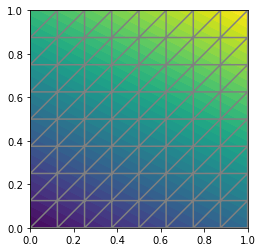

In [5]:
%matplotlib inline
# Ejemplo 5
"""
FEniCS tutorial demo program: Nonlinear Poisson equation.

  -div(q(u)*grad(u)) = f   in the unit square.
                   u = u_D on the boundary.
"""

#from __future__ import print_function

# Warning: from fenics import * will import both `sym` and
# `q` from FEniCS. We therefore import FEniCS first and then
# overwrite these objects.
from fenics import *
import matplotlib.pyplot as plt

def q(u):
    "Return nonlinear coefficient"
    return 1 + u**2

# Use SymPy to compute f from the manufactured solution u
import sympy as sym
x, y = sym.symbols('x[0], x[1]')
u = 1 + x + 2*y
f = - sym.diff(q(u)*sym.diff(u, x), x) - sym.diff(q(u)*sym.diff(u, y), y)
f = sym.simplify(f)
u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)
print('u =', u_code)
print('f =', f_code)

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression(u_code, degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = Function(V)  # Note: not TrialFunction!
v = TestFunction(V)
f = Expression(f_code, degree=2)
F = q(u)*dot(grad(u), grad(v))*dx - f*v*dx

# Compute solution
solve(F == 0, u, bc)

# Plot solution
plot(u)
plot(mesh)

# Save solution to file in XDMF format
xdmffile = XDMFFile('poisson_nonlinear/solution.xdmf')
xdmffile.write(u)

#Hold plot
plt.show()



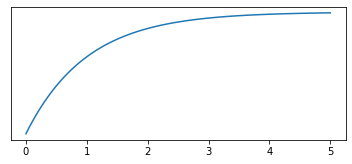

3.748732031105488


In [2]:
%matplotlib inline
from fenics import *
import matplotlib.pyplot as plt

class BoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and \
            (near(x[0], 0.))


#Define mesh
mesh=IntervalMesh(100,0,5)

#Define function space
V=FunctionSpace(mesh,'CG',1)

#Define boundary conditions
#u_D=Expression('5.0',degree=0)

boundaryLeft=BoundaryLeft()
u_0=Constant(5.0)
bc=DirichletBC(V,u_0,boundaryLeft)

#Define variational problem
u=TrialFunction(V)
v=TestFunction(V)
f2=Constant(7.0)

parte1=u.dx(0)+u
a=parte1*v*dx
L=v*f2*dx

u=Function(V)
solve(a==L,u,bc)

plot(u)
plot(mesh)

plt.show()

error_L2=errornorm(u_0,u,'L2')
print(error_L2)

#raw_input("Press enter to continue");